## Policy gradient

In [ ]:
# Install colabgymrender to display gym environments in Colab
!pip install gym[box2d] > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender > /dev/null 2>&1
!pip install imageio==2.4.1 > /dev/null 2>&1

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from gym import wrappers
from colabgymrender.recorder import Recorder

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1417216/45929032 bytes (3.1%)3817472/45929032 bytes (8.3%)6119424/45929032 bytes (13.3%)8880128/45929032 bytes (19.3%)11091968/45929032 bytes (24.2%)13639680/45929032 bytes (29.7%)16220160/45929032 bytes (35.3%)17219584/45929032 bytes (37.5%)18644992/45929032 bytes (40.6%)21012480/45929032 bytes (45.7%)23560192/45929032 bytes (51.3%)26189824/45929032 bytes (57.0%)289

First we create the environment, and look at the properties of it.<br>
The action space consist of 3 values; Steering (which is from -1 to 1, "-1"= full left, "+1"=full right), gas (which is from 0 to 1) and breaking (which is from 0 to 1).<br>
The state space is a 2D 96x96 RGB image of the track and the car.

In [ ]:
env = gym.make('CarRacing-v2', new_step_api=True)   # Create environment
env.reset(options={"randomize": False}, seed = 42)  # Reset it but keep the color scheme, and set the seed

# The state/observation space of the environment
s = env.observation_space                     
print('State space shape:', s.shape)

# The action space of the environment
a = env.action_space
print(f'Action space: [Steering, gas, breaking];  \n\t\tmin_val = {a.low}, \n\t\tmax_val = {a.high}, \n\t\tNo_action = {a.shape[0]}, \n\t\ttype = {a.dtype}' )

State space shape: (96, 96, 3)
Action space: [Steering, gas, breaking];  
		min_val = [-1.  0.  0.], 
		max_val = [1. 1. 1.], 
		No_action = 3, 
		type = float32


We want to convert the state space to a grayscale image, and maybe also tweak around with the action space. For that we use a wrapper to the environment.

In [ ]:
# Grayscale the state, with the predefined wrapper in openAI
env = wrappers.GrayScaleObservation(env)
s = env.observation_space
print('State space shape:', s.shape)

# If we want we can convert "gas" & "break" to acceleration, which will reduce our actionspace to 2 instead of 3
# TO BE DECIDED


State space shape: (96, 96)


Exploring the environment. How to feed an action to the environment and what is returned from the environment.

In [ ]:
# Sampling a random action, and perfom it in the environment
action = env.action_space.sample()
state, reward, terminated, truncated, info = env.step(action)

# Return of the step() function, for more info (line 87-114):
# https://github.com/openai/gym/blob/master/gym/core.py
print('What is returned from the environment, for each step taken:')
print(f'State space shape ({type(state).__name__}): {state.shape}')
print(f'Reward ({type(reward).__name__}): {reward}')
print(f'Terminated ({type(terminated).__name__}): {terminated}')
print(f'Truncated ({type(truncated).__name__}): {truncated}')
print(f'Info ({type(info).__name__}): {info}')

What is returned from the environment, for each step taken:
State space shape (ndarray): (96, 96)
Reward (float): 6.967137809187279
Terminated (bool): False
Truncated (bool): False
Info (dict): {}


Lets make a testrun in the environment, where the agent just takes random actions. The episode will end, if the car hits the outer bounder

In [ ]:
env = gym.make('CarRacing-v2', new_step_api=True) # Create environment
env = Recorder(env, "./video", auto_release = False) # To display environment in Colab
env.reset(options={"randomize": False}, seed = 42) # Reset environment
env = wrappers.GrayScaleObservation(env)

# Run environment
while True:
    action = env.action_space.sample() # Get a random action
    _, _, terminated, truncated, _ = env.step(action) # Take a step
    if terminated or truncated: break # Break if environment is terminated or truncated

# Release the video, this is NEEDED before it can actually play. 
# I would have changed the method in the class, but changing an import is a nono,
# so a scuffed fix is what we have
env.release()
env.close() # Close environment
env.play()

  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."

See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "

  result = np.fromstring(s, dtype='uint8')

  UserWarning)



Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

Let's first define our network and helper functions.

In [ ]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden = nn.Linear(n_inputs, n_hidden)
        self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        print(f'x_shape inside forward {x.shape}')
        x = self.hidden(x)
        x = F.tanh(x)
        x = self.out(x)
        return x
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [ ]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [ ]:
print(env.observation_space)
print(env.action_space)

n_inputs = env.observation_space.shape[0]*env.observation_space.shape[1]
n_hidden = 20
n_outputs = env.action_space.shape[0]

print('state shape:', n_inputs)
print('action shape:', n_outputs)

Box(0, 255, (96, 96), uint8)
Box([-1.  0.  0.], 1.0, (3,), float32)
state shape: 9216
action shape: 3


In [ ]:
def inputsize_correct(s):
    s = np.expand_dims(s.flatten(), axis=0)
    s = torch.from_numpy(np.atleast_2d(s)).float()
    return s

# training settings

num_episodes = 10
rollout_limit = 20 # max rollout length
discount_factor = 0.98 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.004 # you know this by now
val_freq = 100 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s = env.reset()
        s = inputsize_correct(s)
        print(f's_shape inside forward {s.shape}')
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(s)
                a = torch.multinomial(a_prob, num_samples=3).squeeze().numpy()
                print(f'a from distribution: {a}')
                #a = a_prob.squeeze().numpy()
                a[0] = min(max(-1, a[0]),1)
                a[1] = min(max(0, a[1]), 0.99999)
                a[2] = min(max(0, a[2]), 0.9999)
            s1, r, terminated, done, _ = env.step(a)
            s1 = inputsize_correct(s1)
            rollout.append((s, a, r)) # state - action - reward
            s = s1
            if done or terminated: break
        # prepare batch
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0] )
        print(f'shape of states: {states.shape}\n{rollout[1,0].shape}')
        actions = np.vstack(rollout[:,1])
#        print(f'Actions: {actions}')
        rewards = np.array(rollout[:,2], dtype=float) #- (d_from_mid *0.1)
        returns = compute_returns(rewards, discount_factor)
#        print(f'returns: {returns}')
        # policy gradient update
        policy.optimizer.zero_grad()
        #             print(f'Actions in the outer loop: {torch.from_numpy(states).float().shape}')
        a_probs = policy(torch.from_numpy(states).float())#.gather(1, torch.from_numpy(actions)).view(-1)
        print(f'Actions in the outer loop: {a_probs}')
        print(f'Actions in the outer loop (gather): {a_probs.gather(1, torch.from_numpy(actions))}')
        print(f'Actions in the outer loop (view): {a_probs.gather(1, torch.from_numpy(actions)).view(-1)}')
#        print(f'a_probs: {a_probs}')
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a_prob = policy(s)
                        a = torch.multinomial(a_prob, num_samples=3).squeeze().numpy()
                        #a = a_prob.squeeze().numpy()
                        a[0] = min(max(-1, a[0]),1)
                        a[1] = min(max(0, a[1]), 0.99999)
                        a[2] = min(max(0, a[2]), 0.9999)
                    s1, r, terminated, done, _ = env.step(a)
                    reward += r
                    if done or terminated: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')  

  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



start training
s_shape inside forward torch.Size([1, 9216])
x_shape inside forward torch.Size([1, 9216])


RuntimeError: ignored

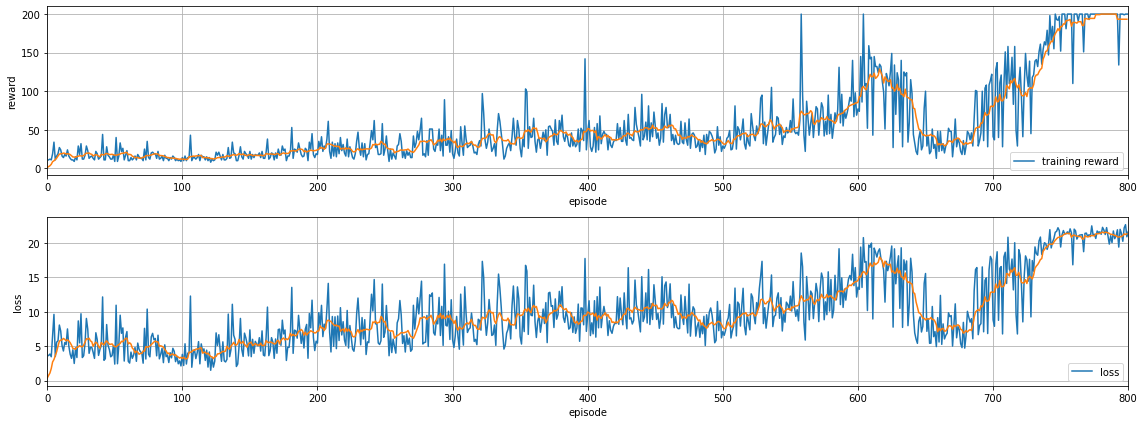

In [ ]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

Now let's review the solution!

In [ ]:
env = Recorder(env, "./gym-results") # wrappers.Monitor(env, "./gym-results", force=True) # Create wrapper to display environment
s = env.reset()

for _ in range(500):
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _ = env.step(a)
    if done: break
    
# env.close()
env.play()

  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."

See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "

  result = np.fromstring(s, dtype='uint8')



## Reducing variance

By default, this gradient estimator has high variance and therefore variance reduction becomes important to learn more complex tasks.
We can reduce variance by subtracting a baseline from the returns, which is unbiased in expectation:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) (R_t-b_t) \ ,
$$

where the baseline, $b_t$, is estimated by the return a timestep $t$ averaged over $V$ rollouts.

$$
b_t = \frac{1}{V} \sum_{v=1}^V R_t^{(v)} \ .
$$

## Exercises

Now it is your turn! Make sure you read and understand the code, then play around with it and try to make it learn better and faster.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* network layers


### Exercise 1 

*Describe any changes you made to the code and why you think they improve the agent. Are you able to get solutions consistently?*

**Answer:**

The learning rate was upped, to make it faster to converge, as the original wasn't even getting the max score within the 800 episodes.<br>
Played around with the discount factor, where the optimal was between 0.97-0.99.<br>
This was enoguh to make the model perform as well as the simulation model allowed it to, meaning that it blanced the pole for 6 seconds, which as a stopping criteria for the simulation.<br>
I tried to punish the model for being farther away from the middle point, but this didn't work.

### Exercise 2 

*Consider the following sequence of rewards produced by an agent interacting with an environment for 10 timesteps:*

[0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

* *What is the total reward?*
* *What is the total future reward in each timestep?*
* *What is the discounted future reward in each timestep if $\gamma = 0.9$?*

*Hint: See introdution notebook.*

**Answer:**

The total reward for the 10 timesteps is 5.<br>
The future rewards in each timestep is; [0, 1, 2, 3, 3, 4, 5, 5, 5, 5].<br>
The discounted future reward in each timestep is; [0, 0.9, 1.7, 2.4, 2.4, 3.0, 3.6, 3.6, 3.6, 3.6].

### Exercise 3

*In the training output, you will sometimes observe the validation reward starts out lower than the training reward but as training progresses they cross over and the validation reward becomes higher than the training reward. How can you explain this behavior?*

*Hint: Do we use the policy network in the same way during training and validation?*

**Answer:**

In the validation calculation, the action set with the highest probablity is chosen. For the training set, the mean of each action set is taken, where the discount factor has been taken into account.

### Exercise 4

*How does the policy gradient method we have used address the exploration-exploitation dilemma?*

*Hint: See the introduction notebook about exploration-exploitation.*

**Answer:**

It is taking the average reward and drawing from the distribution with that value, instead of just choosing the action set which resulted in the best reward. This way we get a sense of exploration, especially in the start, but as we continue going we opt towards exploitation.

### Exercise 5 [optional]

Extend the code above to reduce variance of the gradient estimator by computing and subtracting the baseline estimate. 

*Hint: You need to sample a batch of rollouts (now we sample just one) for each update in order to compute the baseline, $b_t$.*